## Problem Statement

Scaler is an online tech-versity offering intensive computer science & Data Science courses through live classes delivered by tech leaders and subject matter experts. The meticulously structured program enhances the skills of software professionals by offering a modern curriculum with exposure to the latest technologies. It is a product by InterviewBit.

You are working as a data scientist with the analytics vertical of Scaler, focused on profiling the best companies and job positions to work for from the Scaler database. You are provided with the information for a segment of learners and tasked to cluster them on the basis of their job profile, company, and other features. Ideally, these clusters should have similar characteristics.

## Data Dictionary:

- ‘Unnamed 0’- Index of the dataset
- Email_hash- Anonymised Personal Identifiable Information (PII)
- Company- Current employer of the learner
- orgyear- Employment start date
- CTC- Current CTC
- Job_position- Job profile in the company
- CTC_updated_year: Year in which CTC got updated (Yearly increments, Promotions)

In [3]:
#Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [4]:
# Getting the Dataset.
df=pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/856/original/scaler_clustering.csv')

In [5]:
# Checking the first 5 observations.
df.head()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


In [6]:
# Checking the last 5 observations.
df.tail()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
205838,206918,vuurt xzw,70027b728c8ee901fe979533ed94ffda97be08fc23f33b...,2008.0,220000,NaN,2019.0
205839,206919,husqvawgb,7f7292ffad724ebbe9ca860f515245368d714c84705b42...,2017.0,500000,NaN,2020.0
205840,206920,vwwgrxnt,cb25cc7304e9a24facda7f5567c7922ffc48e3d5d6018c...,2021.0,700000,NaN,2021.0
205841,206921,zgn vuurxwvmrt,fb46a1a2752f5f652ce634f6178d0578ef6995ee59f6c8...,2019.0,5100000,NaN,2019.0
205842,206922,bgqsvz onvzrtj,0bcfc1d05f2e8dc4147743a1313aa70a119b41b30d4a1f...,2014.0,1240000,NaN,2016.0


In [7]:
# Checking the shape of the dataset.
df.shape

# Need to check if there are 205843 number of unique learners, otherwise we need to remove/aggregate the duplicate records.

(205843, 7)

In [8]:
# Checking for number of duplicate values in "Unnamed: 0" column
print((df['Unnamed: 0'].duplicated()).sum())
# There are no duplicate values. All the values are unique.

# Dropping the "Unnamed: 0" column
df.drop(columns=['Unnamed: 0'],inplace=True)

0


In [9]:
# Checking for number of duplicate records.
print((df.duplicated()).sum())

# There are 33 duplicate records. We can drop these observations.
df=df[~df.duplicated()]

33


In [10]:
#Resetting the Index.
df.reset_index(drop=True,inplace=True)

In [11]:
# Checking the shape of the dataset.
df.shape

(205810, 6)

In [12]:
# Checking for total number of unique learners using the email-Id column.
df['email_hash'].nunique()

# Total Records:205810,Total Unique Learners:153443.Need to inspect the remaining duplicate records, and then aggregate.

153443

In [13]:
# Finding the list of email_ids for whom we have more than 1 record.
temp=df['email_hash'].value_counts()
duplicated_learners=temp[temp>1].index

# Finding the list of email_ids who have just 1 unique record.
non_duplicated_learners=temp[temp==1].index

print("Total Duplicated Learners",len(duplicated_learners))
print("Total Non-Duplicated Learners",len(non_duplicated_learners))

Total Duplicated Learners 41191
Total Non-Duplicated Learners 112252


In [14]:
# Checking for missing values for every column
df.isna().sum()

# There are no missing values for "email_hash", "ctc" and "ctc_updated_year".
# Need to handle missing values for "company_hash", "orgyear" and "job_position".

company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52547
ctc_updated_year        0
dtype: int64

In [15]:
# Checking the data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205810 entries, 0 to 205809
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   company_hash      205766 non-null  object 
 1   email_hash        205810 non-null  object 
 2   orgyear           205724 non-null  float64
 3   ctc               205810 non-null  int64  
 4   job_position      153263 non-null  object 
 5   ctc_updated_year  205810 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.4+ MB


#### Lets check the duplicated records for few learners to understand how to do the aggregation.

In [16]:
# Checking records of Learner 1
display(df[df['email_hash']==duplicated_learners[7]])

# Observation : The 8 records look almost the same except the ctc and job_position. 

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
37734,bvi ogenfvqt,b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...,2020.0,900000,Engineering Leadership,2021.0
45982,bvi ogenfvqt,b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...,2020.0,900000,Engineering Intern,2021.0
144744,bvi ogenfvqt,b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...,2020.0,900000,Data Analyst,2021.0
151696,bvi ogenfvqt,b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...,2020.0,900000,Data Scientist,2021.0
153848,bvi ogenfvqt,b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...,2020.0,900000,NaN,2021.0
154626,bvi ogenfvqt,b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...,2020.0,900000,Software Engineer 1,2021.0
197115,bvi ogenfvqt,b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...,2020.0,2000000,Engineering Intern,2021.0
203140,bvi ogenfvqt,b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...,2020.0,2000000,Data Analyst,2021.0


In [17]:
# Checking records of Learner 2
display(df[df['email_hash']==duplicated_learners[15]])

# Observation : The 7 records look almost the same except the organisation_year, ctc and job_position. 

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
2396,ouxqg ogrhnxgz uqxcvnt rxbxnta,021ea9c97b6b287336e9345f39f9308c33ccbd15ac366d...,2020.0,300000,Engineering Intern,2021.0
8292,ouxqg ogrhnxgz uqxcvnt rxbxnta,021ea9c97b6b287336e9345f39f9308c33ccbd15ac366d...,2020.0,300000,Other,2021.0
10927,ouxqg ogrhnxgz uqxcvnt rxbxnta,021ea9c97b6b287336e9345f39f9308c33ccbd15ac366d...,2020.0,300000,Backend Engineer,2021.0
35627,ouxqg ogrhnxgz uqxcvnt rxbxnta,021ea9c97b6b287336e9345f39f9308c33ccbd15ac366d...,2020.0,300000,Non Coder,2021.0
88098,ouxqg ogrhnxgz uqxcvnt rxbxnta,021ea9c97b6b287336e9345f39f9308c33ccbd15ac366d...,2022.0,420000,Backend Engineer,2021.0
88137,ouxqg ogrhnxgz uqxcvnt rxbxnta,021ea9c97b6b287336e9345f39f9308c33ccbd15ac366d...,2022.0,420000,Engineering Intern,2021.0
137341,ouxqg ogrhnxgz uqxcvnt rxbxnta,021ea9c97b6b287336e9345f39f9308c33ccbd15ac366d...,2022.0,420000,Other,2021.0


In [18]:
# Checking records of Learner 3
display(df[df['email_hash']==duplicated_learners[36]])

# Observation : The 6 records look almost the same except the job_position and ctc_updated_year. 

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
8336,atigat,8b711b2bb77300ab4bfb6f8bf54d9b28cdd214d8c66e9e...,2018.0,3800000,FullStack Engineer,2019.0
8645,atigat,8b711b2bb77300ab4bfb6f8bf54d9b28cdd214d8c66e9e...,2018.0,3800000,Other,2019.0
22481,atigat,8b711b2bb77300ab4bfb6f8bf54d9b28cdd214d8c66e9e...,2018.0,3800000,Backend Engineer,2019.0
194677,atigat,8b711b2bb77300ab4bfb6f8bf54d9b28cdd214d8c66e9e...,2018.0,3800000,Backend Engineer,2020.0
196770,atigat,8b711b2bb77300ab4bfb6f8bf54d9b28cdd214d8c66e9e...,2018.0,3800000,FullStack Engineer,2020.0
198817,atigat,8b711b2bb77300ab4bfb6f8bf54d9b28cdd214d8c66e9e...,2018.0,3800000,Other,2020.0


In [19]:
# Checking records of Learner 4
display(df[df['email_hash']==duplicated_learners[41]])

# Observation : The 6 records look almost the same except the company_hash, ctc and job_position. 

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
52127,yxuug cxatg,8ffe41ee60bc738df2cb50dbf5c248300b4ddf830093c7...,2019.0,750000,FullStack Engineer,2020.0
58375,yxuug cxatg,8ffe41ee60bc738df2cb50dbf5c248300b4ddf830093c7...,2019.0,750000,NaN,2020.0
143785,nvnv wgzohrnvzwj otqcxwto,8ffe41ee60bc738df2cb50dbf5c248300b4ddf830093c7...,2019.0,396000,Support Engineer,2020.0
144053,nvnv wgzohrnvzwj otqcxwto,8ffe41ee60bc738df2cb50dbf5c248300b4ddf830093c7...,2019.0,396000,Backend Engineer,2020.0
161826,nvnv wgzohrnvzwj otqcxwto,8ffe41ee60bc738df2cb50dbf5c248300b4ddf830093c7...,2019.0,396000,Other,2020.0
165732,nvnv wgzohrnvzwj otqcxwto,8ffe41ee60bc738df2cb50dbf5c248300b4ddf830093c7...,2019.0,396000,NaN,2020.0


#### - To aggregate the duplicate records, lets first sort the dataset according to, "email_hash", decreasing "ctc" and decreasing "ctc_updated_year". 
#### - We can then extract the first record for every learner.

In [20]:
df=df.sort_values(by=['email_hash','ctc','ctc_updated_year'],ascending=[True,False,False])

### Creating Aggregated Dataset

In [21]:
# Getting the first record for every learner.
df=df.groupby(by='email_hash').first().reset_index()

# We can drop the "email_hash" column from the dataset since it's of no use to us anymore.
df.drop(columns='email_hash',inplace=True)

df.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year
0,bxwqgogen,2012.0,3500000,Backend Engineer,2019.0
1,nqsn axsxnvr,2013.0,250000,Backend Engineer,2020.0
2,gunhb,2021.0,1300000,FullStack Engineer,2019.0
3,bxwqgotbx wgqugqvnxgz,2004.0,2000000,FullStack Engineer,2021.0
4,fvrbvqn rvmo,2009.0,3400000,None,2018.0


In [22]:
# Checking for missing values in Percentage.
round(100*df.isna().mean(),2)

# "company_hash" has almost 0.02% missing values.
# "orgyear" has almost 0.05% missing values.
# "job_position" has almost 13.18% missing values.

company_hash         0.02
orgyear              0.05
ctc                  0.00
job_position        13.18
ctc_updated_year     0.00
dtype: float64

In [23]:
# Lets try to first deal with the missing values of "job_position".

# Lets look at the number of unique values of "job_position".
df['job_position'].nunique()

#There are a lot of categories for this column.Lets try doing a few data cleaning techniques to reduce the categories.

813

In [24]:
# First using Regex to try to reduce duplicated categories with special characters.

def function(string):
    if string!=None:
        return re.sub('[^A-Za-z0-9 ]+', '', string)

df['job_position']=df['job_position'].apply(function)

In [25]:
# Lets convert all the "job_position" into lower-case and also removing leading and trailing spaces.
df['job_position']=(df['job_position'].str.lower()).str.strip()

In [26]:
# Lets also remove if there are spaces between the words.
def remove_spaces(job):
    if job !=None:
        job=job.split()
        job=' '.join(job)
        return job

df['job_position']=df['job_position'].apply(remove_spaces)

In [27]:
# Lets check how many categories we have now.
df['job_position'].nunique()

# Great! We were able to remove almost 90 duplicate categories.

721

In [28]:
# Since "job_position" is a categorical variable, lets look at its value_counts.
df['job_position'].value_counts(normalize=True,dropna=False)*100

# Observation : We do not have a clear majority mode here. 
# Lets see try to look at the top 20 occuring job profiles.
(df['job_position'].value_counts(normalize=True)*100)[:20]

backend engineer          27.981744
fullstack engineer        16.064525
other                     11.854916
frontend engineer          6.957716
engineering leadership     4.659245
qa engineer                4.616459
data scientist             3.678154
android engineer           3.672149
sdet                       3.392159
devops engineer            3.229269
support engineer           2.372785
ios engineer               1.926152
data analyst               1.909638
engineering intern         1.580105
product designer           0.957821
product manager            0.801687
backend architect          0.794932
research engineers         0.728124
program manager            0.571990
non coder                  0.399342
Name: job_position, dtype: float64

In [29]:
# We can create 1 new category "Missing" to impute the missing values.
# And we can create another new category "Combined" to combine all the categories whose occurence is less than 1 percent.

df['job_position'].fillna('Missing',inplace=True)

temp=df['job_position'].value_counts(normalize=True)*100
jobs_to_replace=temp[temp<1].index
df.loc[df['job_position'].isin(jobs_to_replace),'job_position']='Combined'

In [30]:
# Lets check if the missing value handling was successful.
df['job_position'].isna().sum()

0

In [31]:
# Lets check how many values are missing for "company_hash"
print('Total Missing Values',df['company_hash'].isna().sum())

# Lets check for the total number of categories in "company_hash"
print('Total Categories',df['company_hash'].nunique())

# Since there are so many companies and the number of missing values are very less, we can drop these rows.
df=df[~df['company_hash'].isna()]


# Lets try using Regex to try to reduce duplicated categories with special characters if present.

def function(string):
    if string!=None:
        return re.sub('[^A-Za-z0-9 ]+', '', string)
df['job_position']=df['job_position'].apply(function)

# Lets check for the total number of categories in "company_hash"
print('Total Categories after Regex',df['company_hash'].nunique())

# Resetting the Index
df.reset_index(drop=True,inplace=True)

Total Missing Values 32
Total Categories 36323
Total Categories after Regex 36323


In [32]:
# Lets check how many values are missing for "orgyear"
print('Total Missing Values:',df['orgyear'].isna().sum())
print()

# Lets check for the total number of categories in "orgyear"
print('Total Categories:',df['orgyear'].nunique())
print()

# Lets look at the possible values of "orgyear"
print(sorted(df['orgyear'].unique().tolist()))
print()

# We can see lot of illogical values such as 0,1,2,208,209,2204,20165. We can drop such rows.
# Lets check the percentage of records that lie between 2005 and 2022. Almost 97.5%, which is a good proportion.
print(df['orgyear'].between(2005,2022).mean()*100,'%')
print()
# We can drop the other observations.

df=df[df['orgyear'].between(2005,2022)]

# Lets check whether the missing values are still present.
print('Total Missing Values:',df['orgyear'].isna().sum())

# Hurrah! The missing values were dropped as part of the previous process.
# There was no need of using KNN imputation to fill the missing values.

# Resetting the Index
df.reset_index(drop=True,inplace=True)

Total Missing Values: 78

Total Categories: 77

[1.0, 1986.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0, 2023.0, nan, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 38.0, 83.0, 91.0, 200.0, 201.0, 206.0, 208.0, 209.0, 1900.0, 1970.0, 1971.0, 1972.0, 1973.0, 1976.0, 1977.0, 1979.0, 1981.0, 1982.0, 1984.0, 1985.0, 1987.0, 1988.0, 2024.0, 2025.0, 2026.0, 2027.0, 2028.0, 2029.0, 2031.0, 2101.0, 2106.0, 2107.0, 2204.0, 20165.0]

96.47352536649915 %

Total Missing Values: 0


In [33]:
# Final Check for presence of missing values.
df.isna().sum()

company_hash        0
orgyear             0
ctc                 0
job_position        0
ctc_updated_year    0
dtype: int64

## New Features

### 1) "Years of Experience"

In [34]:
# We can get this new feature by subtracting "ctc_updated_year" from "orgyear".
df['Years_of_Experience']=df['ctc_updated_year']-df['orgyear']

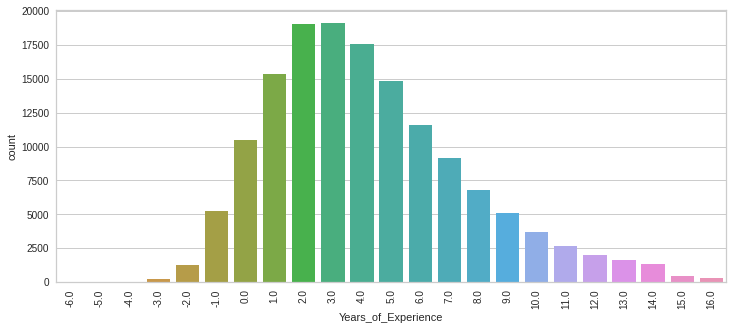

In [35]:
# Lets check if we have only non-negative values of "Years of Experience".
plt.figure(figsize=(12,5))
sns.countplot(data=df,x='Years_of_Experience')
plt.xticks(rotation=90)
plt.show()

In [36]:
# We observed that there are negative values for "Years of Experience", which is not possible in the real world.
# We can therefore drop those records for which "Years of Experience" has negative values.

df=df[df['Years_of_Experience']>=0]

# Resetting the Index
df.reset_index(drop=True,inplace=True)

In [37]:
# Now we can drop the columns "orgyear" and "ctc_updated_year"
df.drop(columns=['orgyear','ctc_updated_year'],inplace=True)

In [38]:
# Lets take a look at our dataset.
df.head(3)

,company_hash,ctc,job_position,Years_of_Experience
0,bxwqgogen,3500000,backend engineer,7.0
1,nqsn axsxnvr,250000,backend engineer,7.0
2,fvrbvqn rvmo,3400000,Missing,9.0


In [39]:
df.shape

(141111, 4)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141111 entries, 0 to 141110
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   company_hash         141111 non-null  object 
 1   ctc                  141111 non-null  int64  
 2   job_position         141111 non-null  object 
 3   Years_of_Experience  141111 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.3+ MB


In [41]:
# Descriptive Statistics for Continuous Columns
display(df[['ctc','Years_of_Experience']].describe().T)

# Observation - The max value of "ctc" is very large. And the min value is strangely very small. Need to inspect further.

,count,mean,std,min,25%,50%,75%,max
ctc,141111.0,2.425988e+06,1.283431e+07,2.0,550000.0,950000.0,1680000.0,1.000150e+09
Years_of_Experience,141111.0,4.471267e+00,3.266160e+00,0.0,2.0,4.0,6.0,1.600000e+01


In [42]:
# Descriptive Statistics for Categorical Columns
display(df[['company_hash', 'job_position']].describe())

,company_hash,job_position
count,141111,141111
unique,33953,16
top,nvnv wgzohrnvzwj otqcxwto,backend engineer
freq,4927,35709


## Analysis

### 1) "ctc"

In [43]:
df[['ctc']].describe().T
# As observed earlier, the max value is very large, and the min value is very small. This could be a potential outlier.

,count,mean,std,min,25%,50%,75%,max
ctc,141111.0,2.425988e+06,1.283431e+07,2.0,550000.0,950000.0,1680000.0,1.000150e+09


In [44]:
# Lets first look at smaller values of "ctc" columns.
# Lets check how many values are smaller than 1 lakh.

print((df['ctc']<100000).mean()*100)

# Almost 2.26 percent data is well below a logical minimum "ctc". Lets assume these are errors and proceed to drop them.

df=df[df['ctc']>=100000]

2.262049025235453


In [45]:
# Now lets look at the larger values of "ctc" column.
# Lets check how many values are greater than 1 crore.

print((df['ctc']>10000000).mean()*100)

# Almost 1.28 percent data is greater than 1 crore. These are not very common "ctc", so lets go ahead and drop them.

df=df[df['ctc']<=10000000]

1.2833619733321733


In [46]:
# Resetting the Index.
df.reset_index(drop=True,inplace=True)

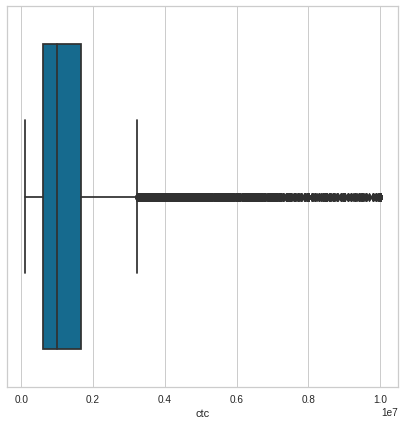

In [47]:
# PLotting the boxplot.
plt.figure(figsize=(7,7))
sns.boxplot(data=df,x='ctc')
plt.show()

# There are very still big values in the "ctc" column. Lets use Log Transformation on "ctc" colum.
df['Log_ctc']=np.log(df['ctc'])

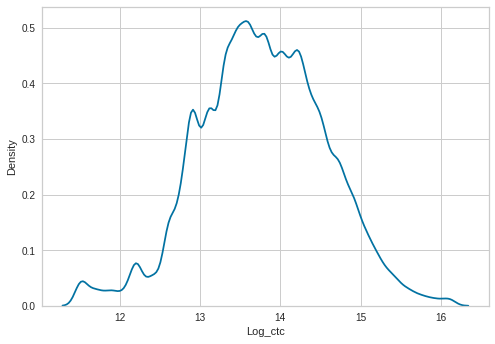

In [48]:
# Lets check the distribution of "ctc" column.
sns.kdeplot(df['Log_ctc'])

# The distribution looks much better. We can use this column instead to find the clusters.

In [49]:
df.shape

(136149, 5)

### 2) "job_position"

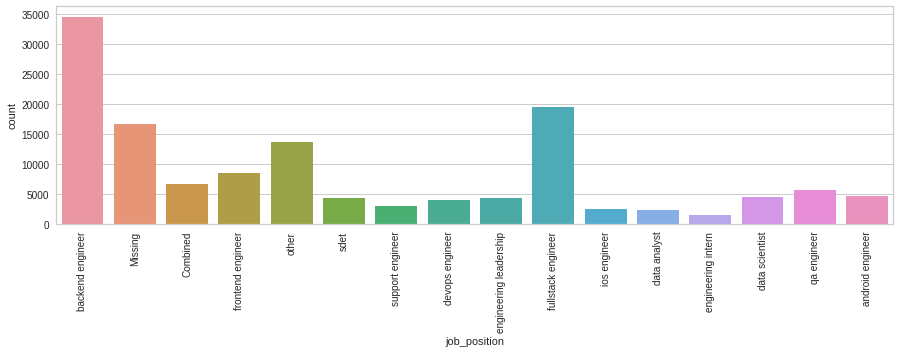

In [50]:
# Lets look at the occurences of each of the "job_position" categories.

plt.figure(figsize=(15,4))
sns.countplot(data=df,x='job_position')
plt.xticks(rotation=90)
plt.show()

# "Backend-Engineer" and  "Fullstack-Engineer" appear the most times.

### 3) "ctc" with "job_position"

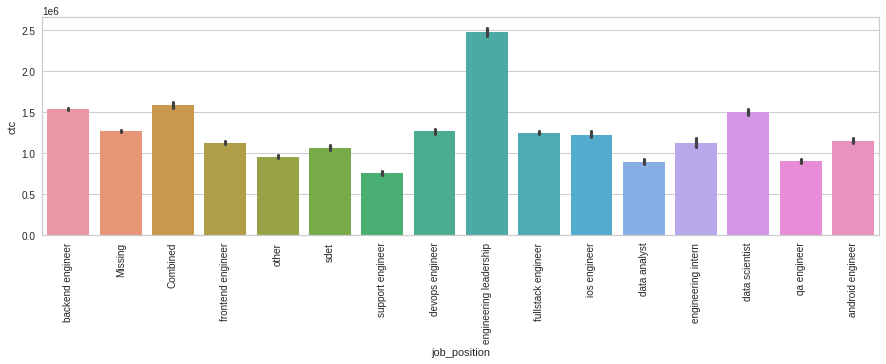

In [51]:
# Lets look at the average salary of each of the job categories.
plt.figure(figsize=(15,4))
sns.barplot(data=df,x='job_position',y='ctc')
plt.xticks(rotation=90)
plt.show()

# "Engineering Leadership" earns the highest average "ctc" among all job categories.
# "Support Engineer" has the minimum average "ctc" among all job categories.

### 4) "Years_of_Experience" with "job_position"

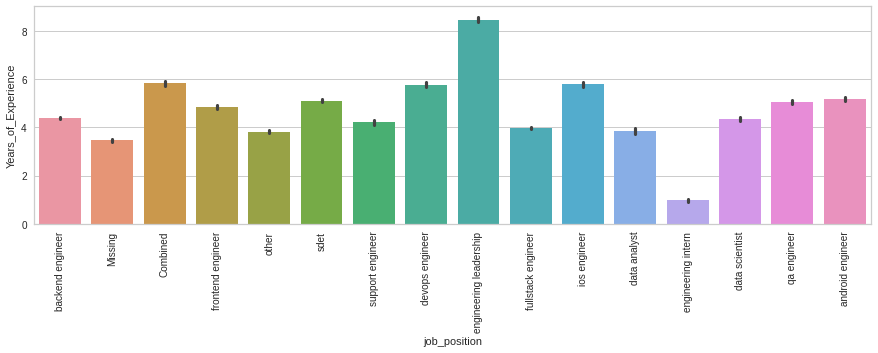

In [52]:
# Lets look at the average salary of each of the job categories.
plt.figure(figsize=(15,4))
sns.barplot(data=df,x='job_position',y='Years_of_Experience')
plt.xticks(rotation=90)
plt.show()

# "Engineering Leadership" has the highest average "Years_of_Experience" among all job categories.
# "Engineering Intern" has the minimum average "Years_of_Experience" among all job categories.

### 5) "company_hash"

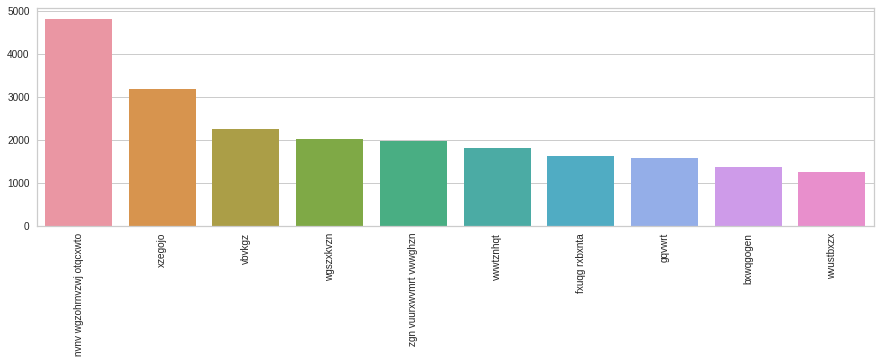

In [53]:
# Lets look at the top 10 companies having most number of jobs.

plt.figure(figsize=(15,4))
temp=df['company_hash'].value_counts().sort_values(ascending=False)[:10]
sns.barplot(x=temp.index,y=temp.values)
plt.xticks(rotation=90)
plt.show()

### 6) "company_hash" with "ctc" 

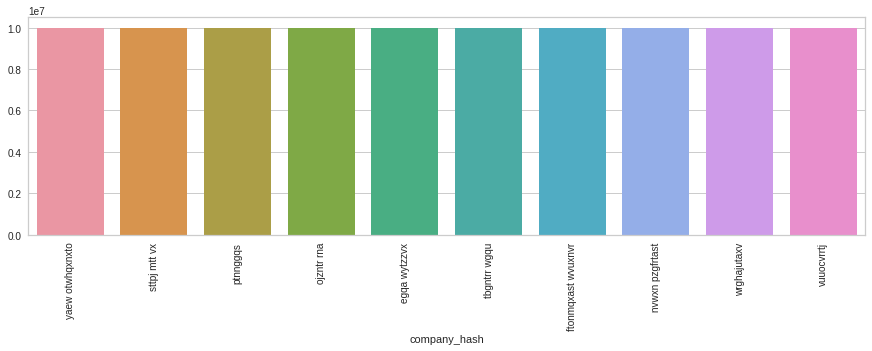

In [54]:
# Lets look at the top 10 companies having average "ctc".

plt.figure(figsize=(15,4))
temp=df.groupby(by='company_hash').mean()['ctc'].sort_values(ascending=False)[:10]
sns.barplot(x=temp.index,y=temp.values)
plt.xticks(rotation=90)
plt.show()

# There are many companies who pay a very big "ctc". All the top 10 "ctc" are identical.

## Manual Clustering

### 1) "Designation Flag"
Creating "Designation_Flag" which shows learners with CTC greater/lower than the Average of their Company’s department having same Years of Experience.

- Before we create the flag, lets specify the rules based on which the flag would be created. 
- If the "ctc" is less than 75% of "average_ctc", we can flag it as 1.
- If the "ctc" is between 75% and 125% of "average_ctc", we can flag it as 2.
- If the "ctc" is grater than 125% of "average_ctc", we can flag it as 3.

In [55]:
# Lets find the "average_ctc" as per the "company_hash","job_position" and "Years_of_Experience". We can name it "Average_1"
temp=df.groupby(by=["company_hash","job_position","Years_of_Experience"]).agg({'ctc':'mean',}).astype('int').reset_index().rename(columns={'ctc':"Average_1"})

# Merging the average_ctc with the dataset.
df=pd.merge(left=df,right=temp,on=["company_hash","job_position","Years_of_Experience"])

In [56]:
# Lets have a look at our updated dataset.
df.head(3)

,company_hash,ctc,job_position,Years_of_Experience,Log_ctc,Average_1
0,bxwqgogen,3500000,backend engineer,7.0,15.068274,3286052
1,bxwqgogen,3560000,backend engineer,7.0,15.085271,3286052
2,bxwqgogen,5500000,backend engineer,7.0,15.520259,3286052


In [57]:
# Lets create a function to create the "Designation_Flag" column.
def function(arr):
    if arr[0]>(1.25*arr[1]):
        return 3
    elif arr[0]<(0.75*arr[1]):
        return 1
    else:
        return 2

# Lets get the values of "Designation_Flag"
df['Designation_Flag']=df[['ctc','Average_1']].apply(function,axis=1)

# We can now drop the "Average_1" column.
df.drop(columns=['Average_1'],inplace=True)

In [58]:
# Lets have a look at our updated dataset.
df.head(3)

,company_hash,ctc,job_position,Years_of_Experience,Log_ctc,Designation_Flag
0,bxwqgogen,3500000,backend engineer,7.0,15.068274,2
1,bxwqgogen,3560000,backend engineer,7.0,15.085271,2
2,bxwqgogen,5500000,backend engineer,7.0,15.520259,3


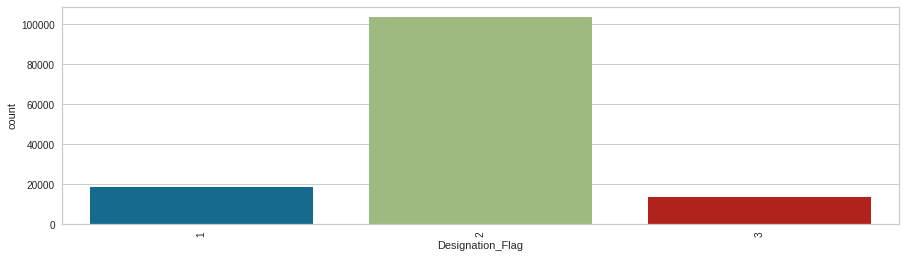

In [59]:
# Lets look at the percentage of people beloonging to each type of "Designation_Flag".
plt.figure(figsize=(15,4))
sns.countplot(data=df,x='Designation_Flag')
plt.xticks(rotation=90)
plt.show()

# There are more people who earn almost equal to the average salary as per their "company_hash","job_position","Years_of_Experience".
# There is a small section of learners who earn either very large or very large ctc.

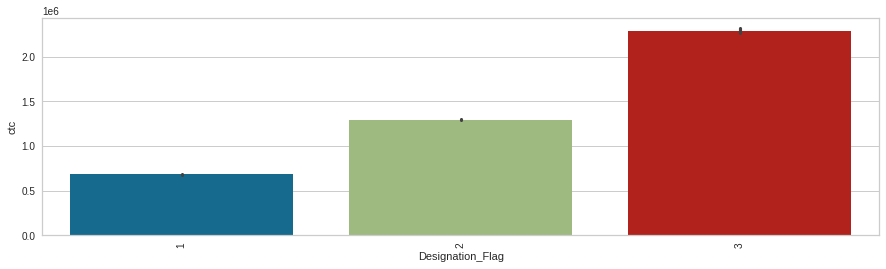

In [60]:
# Lets look at the relationship of "Designation_Flag" with "ctc".
plt.figure(figsize=(15,4))
sns.barplot(data=df,x='Designation_Flag',y='ctc')
plt.xticks(rotation=90)
plt.show()

# We can see a good difference between the relative ctcs between flag_1, flag_2 and flag_3.

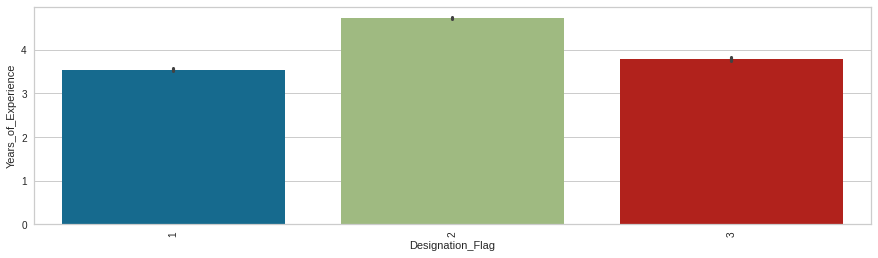

In [61]:
# Lets look at the relationship of "Designation_Flag" with "Years_of_Experience".
plt.figure(figsize=(15,4))
sns.barplot(data=df,x='Designation_Flag',y='Years_of_Experience')
plt.xticks(rotation=90)
plt.show()

# This is an interesting discovery. Learners who earn the highest salaries do not have the highest "Years_of_Experience".

### 2) "Class Flag"
Creating "Class_Flag" which shows learners with CTC greater/lower than the Average of their Company’s department.

- Before we create the flag, lets specify the rules based on which the flag would be created. 
- If the "ctc" is less than 75% of "average_ctc", we can flag it as 1.
- If the "ctc" is between 75% and 125% of "average_ctc", we can flag it as 2.
- If the "ctc" is grater than 125% of "average_ctc", we can flag it as 3.

In [62]:
# Lets find the "average_ctc" as per the "company_hash" and "job_position". We can name it "Average_2"
temp=df.groupby(by=["company_hash","job_position"]).agg({'ctc':'mean',}).astype('int').reset_index().rename(columns={'ctc':"Average_2"})

# Merging the average_ctc with the dataset.
df=pd.merge(left=df,right=temp,on=["company_hash","job_position"])

In [63]:
# Lets have a look at our updated dataset.
df.head(3)

,company_hash,ctc,job_position,Years_of_Experience,Log_ctc,Designation_Flag,Average_2
0,bxwqgogen,3500000,backend engineer,7.0,15.068274,2,2873402
1,bxwqgogen,3560000,backend engineer,7.0,15.085271,2,2873402
2,bxwqgogen,5500000,backend engineer,7.0,15.520259,3,2873402


In [64]:
# Lets get the values of "Class_Flag"
df['Class_Flag']=df[['ctc','Average_2']].apply(function,axis=1)

# We can now drop the "Average_1" column.
df.drop(columns=['Average_2'],inplace=True)

In [65]:
# Lets have a look at our updated dataset.
df.head(3)

,company_hash,ctc,job_position,Years_of_Experience,Log_ctc,Designation_Flag,Class_Flag
0,bxwqgogen,3500000,backend engineer,7.0,15.068274,2,2
1,bxwqgogen,3560000,backend engineer,7.0,15.085271,2,2
2,bxwqgogen,5500000,backend engineer,7.0,15.520259,3,3


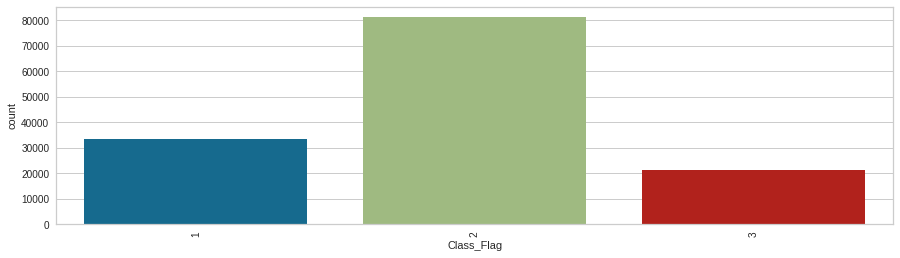

In [66]:
# Lets look at the percentage of people belionging to each type of "Class_Flag".
plt.figure(figsize=(15,4))
sns.countplot(data=df,x='Class_Flag')
plt.xticks(rotation=90)
plt.show()

# There are more people who earn almost equal to the average salary as per their "company_hash" and "job_position"
# There is a small section of learners who earn either very large or very large ctc.

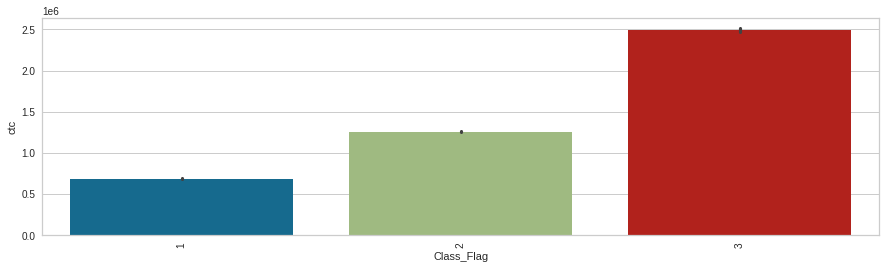

In [67]:
# Lets look at the relationship of "Class_Flag" with "ctc".
plt.figure(figsize=(15,4))
sns.barplot(data=df,x='Class_Flag',y='ctc')
plt.xticks(rotation=90)
plt.show()

# We can see a good difference between the relative ctcs between flag_1, flag_2 and flag_3.

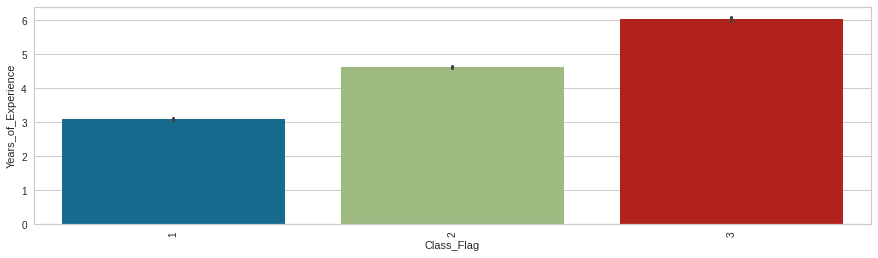

In [68]:
# Lets look at the relationship of "Class_Flag" with "Years_of_Experience".
plt.figure(figsize=(15,4))
sns.barplot(data=df,x='Class_Flag',y='Years_of_Experience')
plt.xticks(rotation=90)
plt.show()

# Learners who earn the highest salaries have the highest "Years_of_Experience".

### 3) "Tier Flag"
Creating "Tier_Flag" which shows learners with CTC greater/lower than the Average of their Company.

- Before we create the flag, lets specify the rules based on which the flag would be created. 
- If the "ctc" is less than 75% of "average_ctc", we can flag it as 1.
- If the "ctc" is between 75% and 125% of "average_ctc", we can flag it as 2.
- If the "ctc" is grater than 125% of "average_ctc", we can flag it as 3.

In [69]:
# Lets find the "average_ctc" as per the "company_hash". We can name it "Average_3"
temp=df.groupby(by=["company_hash"]).agg({'ctc':'mean',}).astype('int').reset_index().rename(columns={'ctc':"Average_3"})

# Merging the average_ctc with the dataset.
df=pd.merge(left=df,right=temp,on=["company_hash"])

In [70]:
# Lets have a look at our updated dataset.
df.head(3)

,company_hash,ctc,job_position,Years_of_Experience,Log_ctc,Designation_Flag,Class_Flag,Average_3
0,bxwqgogen,3500000,backend engineer,7.0,15.068274,2,2,2792920
1,bxwqgogen,3560000,backend engineer,7.0,15.085271,2,2,2792920
2,bxwqgogen,5500000,backend engineer,7.0,15.520259,3,3,2792920


In [71]:
# Lets get the values of "Tier_Flag"
df['Tier_Flag']=df[['ctc','Average_3']].apply(function,axis=1)

# We can now drop the "Average_1" column.
df.drop(columns=['Average_3'],inplace=True)

In [72]:
# Lets have a look at our updated dataset.
df.head(3)

,company_hash,ctc,job_position,Years_of_Experience,Log_ctc,Designation_Flag,Class_Flag,Tier_Flag
0,bxwqgogen,3500000,backend engineer,7.0,15.068274,2,2,3
1,bxwqgogen,3560000,backend engineer,7.0,15.085271,2,2,3
2,bxwqgogen,5500000,backend engineer,7.0,15.520259,3,3,3


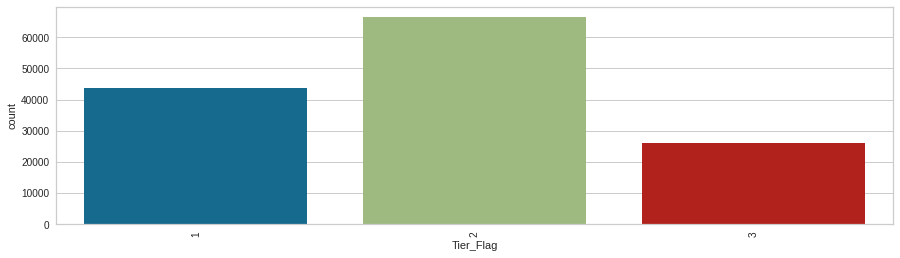

In [73]:
# Lets look at the percentage of people belionging to each type of "Tier_Flag".
plt.figure(figsize=(15,4))
sns.countplot(data=df,x='Tier_Flag')
plt.xticks(rotation=90)
plt.show()

# There are more people who earn almost equal to the average salary as per their "company_hash".
# There is a small section of learners who earn either very large or very large ctc.

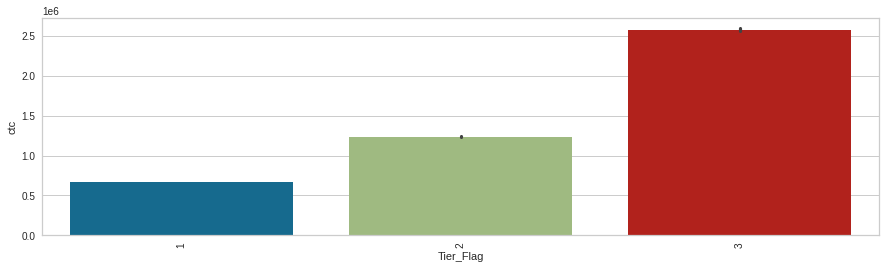

In [74]:
# Lets look at the relationship of "Tier_Flag" with "ctc".
plt.figure(figsize=(15,4))
sns.barplot(data=df,x='Tier_Flag',y='ctc')
plt.xticks(rotation=90)
plt.show()

# We can see a good difference between the relative ctcs between flag_1, flag_2 and flag_3.

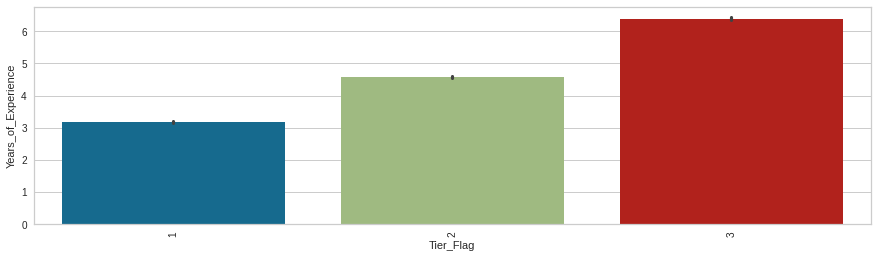

In [75]:
# Lets look at the relationship of "Tier_Flag" with "Years_of_Experience".
plt.figure(figsize=(15,4))
sns.barplot(data=df,x='Tier_Flag',y='Years_of_Experience')
plt.xticks(rotation=90)
plt.show()

# Learners who earn the highest salaries have the highest "Years_of_Experience".

## Encoding

In [76]:
# Lets check which columns we need to encode.
display(df.head(2))

# Since "company_hash" has a lot of categories, we can drop it for doing clustering.
# For doing clustering, we can also drop "Designation_Flag", "Class_Flag" and "Tier_Flag".
# Also, we can drop "ctc" column since we have a new column - "Log_ctc".
# We need to One-Hot-Encode "job_position"

df=df[['job_position', 'Years_of_Experience', 'Log_ctc']]
encoder=OneHotEncoder(sparse=False)
temp=pd.DataFrame(data=encoder.fit_transform(df[['job_position']]),columns=encoder.get_feature_names())
df=pd.concat((df.iloc[:,1:],temp),axis=1)

,company_hash,ctc,job_position,Years_of_Experience,Log_ctc,Designation_Flag,Class_Flag,Tier_Flag
0,bxwqgogen,3500000,backend engineer,7.0,15.068274,2,2,3
1,bxwqgogen,3560000,backend engineer,7.0,15.085271,2,2,3


## Scaling

In [77]:
# Lets check which columns we need to encode.
display(df.head(2))

# We need to scale "Years_of_Experience" and "Log_ctc".
scaler=StandardScaler()
temp=pd.DataFrame(data=scaler.fit_transform(df.iloc[:,[0,1]]),columns=scaler.get_feature_names_out())
df=pd.concat((temp,df.iloc[:,2:]),axis=1)

,Years_of_Experience,Log_ctc,x0_Combined,x0_Missing,x0_android engineer,x0_backend engineer,x0_data analyst,x0_data scientist,x0_devops engineer,x0_engineering intern,x0_engineering leadership,x0_frontend engineer,x0_fullstack engineer,x0_ios engineer,x0_other,x0_qa engineer,x0_sdet,x0_support engineer
0,7.0,15.068274,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.0,15.085271,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
# Final Look at our encoded and scaled dataset.
df.head(2)

,Years_of_Experience,Log_ctc,x0_Combined,x0_Missing,x0_android engineer,x0_backend engineer,x0_data analyst,x0_data scientist,x0_devops engineer,x0_engineering intern,x0_engineering leadership,x0_frontend engineer,x0_fullstack engineer,x0_ios engineer,x0_other,x0_qa engineer,x0_sdet,x0_support engineer
0,0.774817,1.631987,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.774817,1.653532,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Unsupervised Learning - Clustering

## 1) K-Means Clustering

In [ ]:
# Lets use KMeans clustering to find the optimal number of clusters. Lets try for clusters 2,3,4,5 and 6.
inertias=[]
silhouette_scores=[]
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df) for k in range(2, 7)]

# Inertia and Silhouette_Scores for deciding the optimal number of clusters
inertias = [model.inertia_ for model in kmeans_per_k]
silhouette_scores = [silhouette_score(df, model.labels_) for model in kmeans_per_k]

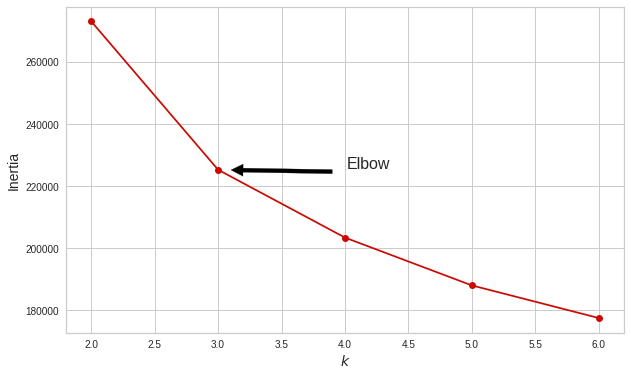

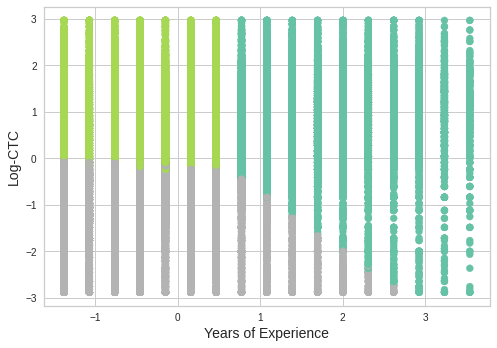

In [ ]:
# Elbow method to determine the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2,7), inertias, "ro-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow', xy=(3, inertias[1]), xytext=(0.55, 0.55), textcoords='figure fraction',
             fontsize=16, arrowprops=dict(facecolor='black', shrink=0.1))
plt.show()

# From the elbow method, we can see a sharp bend for k=3. Lets look at the segmenation for 3 clusters.
plt.scatter(x=df['Years_of_Experience'],y=df['Log_ctc'],c=kmeans_per_k[1].labels_,cmap='Set2')
plt.xlabel("Years of Experience", fontsize=14)
plt.ylabel("Log-CTC", fontsize=14)
plt.show()

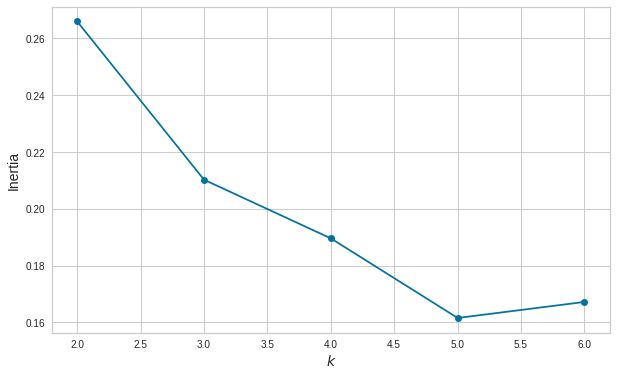

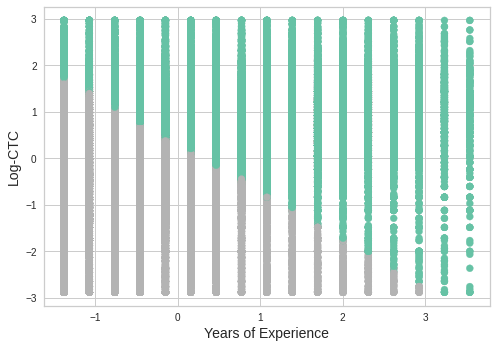

In [ ]:
# Silhouette_scores to determine the optimal number of clusters.
plt.figure(figsize=(10, 6))
plt.plot(range(2,7), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

# From this plot, k=2 or k=3 is the right number of clusters. Lets look at the segmenation for 2 clusters.
plt.scatter(x=df['Years_of_Experience'],y=df['Log_ctc'],c=kmeans_per_k[0].labels_,cmap='Set2')
plt.xlabel("Years of Experience", fontsize=14)
plt.ylabel("Log-CTC", fontsize=14)
plt.show()

In [ ]:
# Observation - 3 Clusters are more suitable according to the business sense.
# - The first cluster belongs to those young learners who are probably highly skilled and have joined high paying startups and MNCs.
# - The second cluster belongs to those learner who are probably working in service based MNCs and their salary increases with experience.
# - The third cluster belongs to those learner who are probably working in top product based companies and are very skillful and experienced.


## 2) Hierarchical Clustering

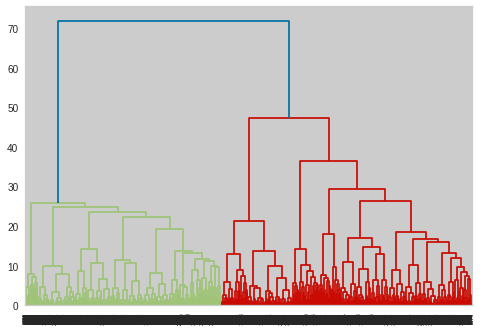

In [81]:
# Lets see how many clusters "Hierarchical Clustering" on its own.
# Since it will take a lot of time to run the algorithm on the entire dataset, therefore lets take only 5,000 observations.

linkage_data = linkage(df.sample(4000), method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.show()

# From the above plot we can see that the number of clusters is 3, which is also verfied by the Elbow method from K_Means.

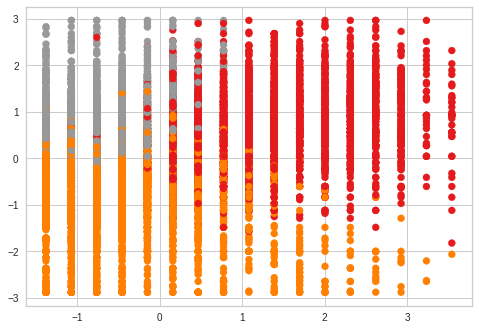

In [86]:
# Lets look at the segmentation of the 3 clusters by using "Hierarchical_Clustering".
# Since it will take a lot of time to run the algorithm on the entire dataset, therefore lets take only 15,000 observations.
data=df.sample(15000)

hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(data)

plt.scatter(data['Years_of_Experience'], data['Log_ctc'], c=labels,cmap='Set1')
plt.show()

# The segmentation of clusters by using "Hierarchical_Clustering" is almost the same as by using "KMeans".

# Actionable Insights & Recommendations

- From the clustering analysis and also by business intuition, we finally deciced that there are 3 meaningful clusters.
- The first cluster belongs to those young learners who are probably highly skilled and have joined high paying startups and MNCs.
- The second cluster belongs to those learner who are probably working in service based MNCs and their salary increases with experience.
- The third cluster belongs to those learner who are probably working in top product based companies and are very skillful and experienced.
- For very high paying start-ups for less experienced learners, Scaler can identify, train and make them ready to crack those jobs.
- For stable MNCs, learners who are not highly skilled or who are looking to do a career transition can be placed in such companies.
- For highly experienced jobs, some learners can be identified who are both skillful and highly experieced to get those jobs.
- There are a lot of "Backend-Engineer" and  "Fullstack-Engineer" jobs available, so getting learned placed for this job role would be relatively easy.
- "Engineering Leadership" earns the highest average "ctc" among all job categories, and these learners have the highest average experience. A highly experienced learner might be better suited for "Engineering Leadership" job.
- "Support Engineer" has the minimum average "ctc" among all job categories. This can be a good marketing strategy to attract learners who are looking to do a career transition.
- As expected, "Engineering Intern" has the minimum average "Years_of_Experience" among all job categories.
- "Data Scientist" and "Backend Engineer" are one of the most highly paid jobs, and Scaler's program these program for both these job profiles. So Scaler can get learner placed in such jobs easily.
- There are a few masked companies who hire a lot of people, so Scaler can also placed suitable learners in these companies based on the job fit requirement.
- There are a few companies who offer the best salaries to its employees. Scaler can shortlist such learners from its cohort and try to get learners placed in them to increase its credibility.